In [1]:
## Updated 1-7-25


import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io
import random
from joblib import load
import time
import processing
import unsupervised_scripts
import helper_scripts
from tkinter import Tk, filedialog



wavenum_1 = int(input('Enter first wavenumber/higher wavelength (Default=2700)): ').strip() or '2700')
wavenum_2 = int(input('Enter last wavenumber/lower wavelength (Default=3100): ').strip() or '3100')

data = processing.load_data(wavenum_1, wavenum_2)
spectra, img_dict, og_spectra = data.load_spectra()
background = data.create_background('water_HSI_76.csv')
mean_spectra = np.mean(spectra, axis=1)
background = processing.normalize(background, mean_spectra[-1], np.median(mean_spectra[:data.ch_start]))
corrected_spectra = (spectra.T-background)
image_vec = corrected_spectra


num_samp = data.num_samp
ch_start = data.ch_start
background_df = pd.read_csv('water_HSI_76.csv')
molecule_df = pd.read_csv('lipid_subtype_CH_61.csv')

## Load artificial dataset
mol_names = np.array(molecule_df.columns)[1:]
mol_names = np.append(mol_names, "Background")
X_data = np.load('artificial_data/artificial_training_data-'+str(wavenum_1)+'_'+str(wavenum_2)+'_'+str(num_samp)+'.npy')
Y_data = np.tile(mol_names, (X_data.shape[0], 1))
X = np.reshape(X_data, (X_data.shape[0] * X_data.shape[1], X_data.shape[2]))
Y = np.reshape(Y_data, (Y_data.shape[0] * Y_data.shape[1]))


## Process both datasets
preprocessing = unsupervised_scripts.preprocessing(wavenum_1, wavenum_2, num_samp, ch_start, background_df)
X_norm  = preprocessing.spectral_standardization(np.flip(X,axis=1))
# mean_X = np.mean(X_norm, axis=1)
# background = processing.normalize(background, mean_X[-1], np.median(mean_X[:data.ch_start]))
# X_norm = (X_norm-background)
image_norm = image_vec

save_input = unsupervised_scripts.save_input()


2025-03-07 23:51:49.563 python[2599:162792] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-07 23:51:49.754 python[2599:162792] The class 'NSOpenPanel' overrides the method identifier.  This method is implemented by class 'NSWindow'
2it [00:02,  1.11s/it]


Text(0.5, 1.0, 'Spectra Peak Intensity')

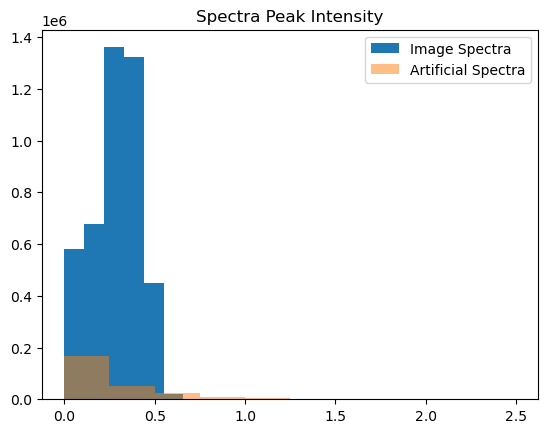

In [3]:
plt.hist(np.max(image_norm,axis=1)-image_norm[:,0], label = "Image Spectra")
plt.hist(np.max(X_norm,axis=1)-X_norm[:,0],alpha=0.5, label = "Artificial Spectra")
plt.legend()
plt.title("Spectra Peak Intensity")

In [26]:
def macro_idx(wavenumber, num_samp, wavenum_1=2700, wavenum_2=3100):
    idx = int(((wavenumber - wavenum_1) / (wavenum_2 - wavenum_1)) * num_samp)
    return idx

In [27]:
## Save Normalized Image and channels (ONLY FOR 2700-3100)
unsat_idx = macro_idx(3010, num_samp, wavenum_1, wavenum_2)
protein_idx = macro_idx(2938, num_samp, wavenum_1, wavenum_2)
sat_idx = macro_idx(2885, num_samp, wavenum_1, wavenum_2)
lipid_idx = macro_idx(2850, num_samp, wavenum_1, wavenum_2)



norm_image = np.reshape(image_norm, (image.shape[1],image.shape[2],image.shape[0]))
norm_image = np.moveaxis(norm_image, 2, 0)
io.imsave(save_dir+'normalized-'+sample_name, norm_image.astype('float32'))
io.imsave(save_dir+'normalized-unsat-'+sample_name, np.max(norm_image[list(range(unsat_idx-1, unsat_idx+1))],axis=0).astype('float32'))
io.imsave(save_dir+'normalized-protein-'+sample_name, np.max(norm_image[list(range(protein_idx-1, protein_idx+1))],axis=0).astype('float32'))
io.imsave(save_dir+'normalized-sat-'+sample_name, np.max(norm_image[list(range(sat_idx-1, sat_idx+1))],axis=0).astype('float32'))
io.imsave(save_dir+'normalized-lipid-'+sample_name, np.max(norm_image[list(range(lipid_idx-1, lipid_idx+1))],axis=0).astype('float32'))

NameError: name 'image' is not defined

Text(0, 0.5, 'Normalized Intensity (A.U.)')

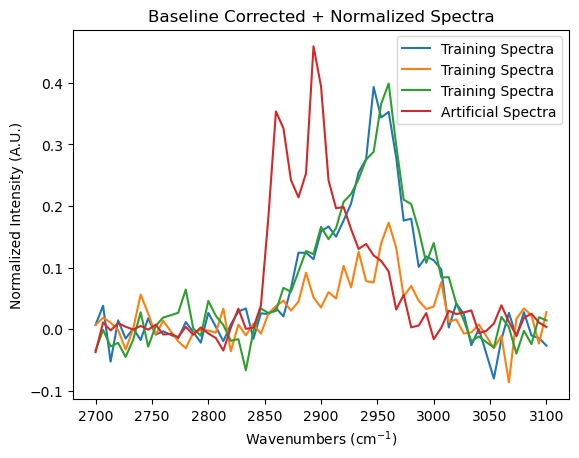

In [8]:
## Visualize random spectra for validation of preprocessing

wavenumbers = np.linspace(wavenum_1, wavenum_2, num_samp)
indeces = [random.randint(0,image_norm.shape[0]-1), random.randint(0,image_norm.shape[0]-1), random.randint(0,image_norm.shape[0]-1)]
plt.plot(wavenumbers, image_norm[indeces].T, label = 'Training Spectra')
plt.plot(wavenumbers, X_norm[np.random.randint(0,X_norm.shape[0])].T, label = 'Artificial Spectra')
plt.legend()
plt.title('Baseline Corrected + Normalized Spectra')
plt.xlabel('Wavenumbers (cm$^{-1}$)')
plt.ylabel('Normalized Intensity (A.U.)')

In [ ]:
# ## Optimize Smoothing of HSI and artificial spectra
# w = int(input('Enter window size for Savitzky-Golay smoothing (Default=6): ').strip() or '6')
# p = int(input('Enter polynomial for Savitzky-Golay smoothing (Default=3): ').strip() or '3')
# preprocessing.sav_gol_optimization(image_norm, w, p)
# preprocessing.sav_gol_optimization(X_norm, w, p)
# x = savgol_filter(image_norm,w,p, axis=1, mode='mirror')
# X = savgol_filter(X_norm,w,p, axis=1, mode='mirror')
# smooth = 'smoothing-'+str(w)+'-'+str(p)

In [ ]:
## No smoothing (OPTIONAL)
x = image_norm
X = X_norm

smooth = 'No Smoothing'

In [ ]:
## Random Forest Classification
rf_classifier = unsupervised_scripts.RF_classify(x, X, Y, .25)
num_estimators =500
rfc = load('rf_classifiers/rfc-'+smooth+'_'+str(wavenum_1)+'_'+str(wavenum_2)+'_'+str(num_samp)+'_'+str(num_estimators)+'.joblib')
print('Accuracy Score: ' + str(rfc.score(rf_classifier.X_train, rf_classifier.y_train)))
rf_classifier.confusion_matrix(mol_names, rfc)

In [ ]:
## USe Random Forest Classifier on Unlabeled HSI
start_time = time.time()
outputs = unsupervised_scripts.semi_supervised_outputs(x, mol_names, rfc)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

In [ ]:
## Spectral Graphs
# save_input = helper_scripts.save_input()
wavenumbers = np.linspace(wavenum_1, wavenum_2, num_samp)
outputs.spectral_graphs(mol_norm, wavenumbers, save_input, save_dir)
outputs.probability_images(image, save_input, save_dir)

In [ ]:
import helper_scripts
print('Save similarity metric .csv?')
ave_input = helper_scripts.save_input()
outputs.similarity_metrics(mol_norm, save_input, save_dir)